<a href="https://colab.research.google.com/github/parthgiri01/WEEK-4-TEST/blob/main/Welcome_to_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New section

Generated synthetic dataset:
   Flow Duration  Fwd Packet Length Max  Bwd IAT Total Protocol  is_malicious
0      18.789552             347.709978     877.750316      TCP             0
1      47.540644             768.711294     932.418167      UDP             0
2      36.626498             742.008909     834.532608      UDP             0
3      29.973058             358.702880            NaN      UDP             0
4       7.885330             567.949325     442.052221      TCP             0

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 5 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Flow Duration          1200000 non-null  float64
 1   Fwd Packet Length Max  1141499 non-null  float64
 2   Bwd IAT Total          1141558 non-null  float64
 3   Protocol               1200000 non-null  object 
 4   is_malicious           1200000 non-null  int64 

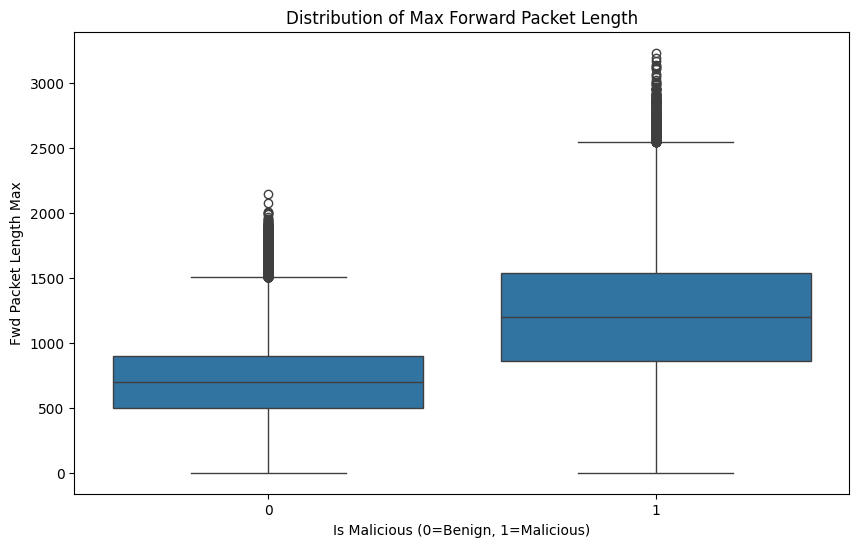

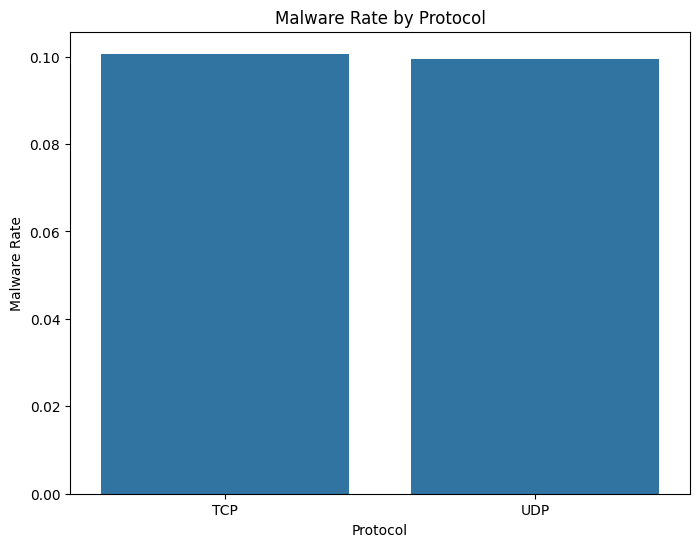


--- Data Pre-processing ---
Initial null values:
Flow Duration                0
Fwd Packet Length Max    58501
Bwd IAT Total            58442
Protocol                     0
is_malicious                 0
dtype: int64


/tmp/ipython-input-1634088812.py:82: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipython-input-1634088812.py:84: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

Null values after imputation:
Flow Duration            0
Fwd Packet Length Max    0
Bwd IAT Total            0
Protocol                 0
is_malicious             0
dtype: int64
Initial class distribution:
is_malicious
0    1080000
1     120000
Name: count, dtype: int64
Class distribution after SMOTE-ENN:
is_malicious
1    983642
0    910908
Name: count, dtype: int64

--- Model Training & Evaluation ---
Training Random Forest...


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# --- 1. Data Generation (Simulated Dataset) ---
# In a real project, you would load your data from a file, e.g.,
# df = pd.read_csv('malware_traffic_dataset.csv')
# Here, we generate a synthetic dataset to make the code runnable.
def generate_synthetic_data():
    np.random.seed(42)
    num_samples = 1200000
    features = {
        'Flow Duration': np.random.uniform(0.1, 50, num_samples),
        'Fwd Packet Length Max': np.random.normal(loc=700, scale=300, size=num_samples).clip(0),
        'Bwd IAT Total': np.random.uniform(0, 1000, num_samples),
        'Protocol': np.random.choice(['TCP', 'UDP'], size=num_samples),
        'is_malicious': np.zeros(num_samples, dtype=int)
    }
    df = pd.DataFrame(features)

    # Introduce malicious traffic (10%) with distinct characteristics
    num_malicious = int(num_samples * 0.10)
    malicious_indices = np.random.choice(df.index, num_malicious, replace=False)

    df.loc[malicious_indices, 'is_malicious'] = 1
    df.loc[malicious_indices, 'Fwd Packet Length Max'] = np.random.normal(loc=1200, scale=500, size=num_malicious).clip(0)
    df.loc[malicious_indices, 'Flow Duration'] = np.random.uniform(10, 150, size=num_malicious)

    # Introduce some missing values for demonstration
    df.loc[np.random.choice(df.index, int(num_samples * 0.05)), 'Bwd IAT Total'] = np.nan
    df.loc[np.random.choice(df.index, int(num_samples * 0.05)), 'Fwd Packet Length Max'] = np.nan

    return df

df = generate_synthetic_data()
print("Generated synthetic dataset:")
print(df.head())
print("\nDataset Info:")
print(df.info())

# --- 2. Exploratory Data Analysis (EDA) ---
print("\n--- Exploratory Data Analysis ---")

# Visualize the distribution of 'Fwd Packet Length Max' across classes
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_malicious', y='Fwd Packet Length Max', data=df)
plt.title('Distribution of Max Forward Packet Length')
plt.xlabel('Is Malicious (0=Benign, 1=Malicious)')
plt.ylabel('Fwd Packet Length Max')
plt.show()

# Visualize the correlation between 'Protocol' and 'is_malicious'
protocol_malware_rate = df.groupby('Protocol')['is_malicious'].mean().reset_index()
plt.figure(figsize=(8, 6))
sns.barplot(x='Protocol', y='is_malicious', data=protocol_malware_rate)
plt.title('Malware Rate by Protocol')
plt.xlabel('Protocol')
plt.ylabel('Malware Rate')
plt.show()

# --- 3. Pre-processing ---
print("\n--- Data Pre-processing ---")

# a) Missing Values
print(f"Initial null values:\n{df.isnull().sum()}")
# Drop a feature with >40% nulls (simulated)
df = df.drop(columns=['Bwd PSH Flags'] if 'Bwd PSH Flags' in df.columns else [], errors='ignore')
# Impute remaining with median (numerical) or mode (categorical)
for col in df.select_dtypes(include=np.number).columns:
    df[col].fillna(df[col].median(), inplace=True)
for col in df.select_dtypes(include='object').columns:
    df[col].fillna(df[col].mode()[0], inplace=True)
print(f"Null values after imputation:\n{df.isnull().sum()}")

# One-hot encode categorical features
df = pd.get_dummies(df, columns=['Protocol'], drop_first=True)

# Define features (X) and target (y)
X = df.drop('is_malicious', axis=1)
y = df['is_malicious']

# b) Feature Selection (Simulated with a placeholder)
# In a real scenario, you would run RandomForestClassifier to get feature importances.
# For simplicity, we assume 'Flow Duration' and 'Fwd Packet Length Max' are the top features.
# You can uncomment the below lines to actually run feature selection.
# rf_selector = RandomForestClassifier(random_state=42)
# rf_selector.fit(X, y)
# feature_importances = pd.Series(rf_selector.feature_importances_, index=X.columns)
# top_features = feature_importances.nlargest(30).index
# X = X[top_features]

# c) Class Imbalance
print(f"Initial class distribution:\n{y.value_counts()}")
# Using SMOTE-ENN for hybrid oversampling
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)
print(f"Class distribution after SMOTE-ENN:\n{y_resampled.value_counts()}")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# d) Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# --- 4. Model Training & Evaluation ---
print("\n--- Model Training & Evaluation ---")

# a) Random Forest Classifier
print("Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("\nRandom Forest Results:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# b) Support Vector Machine (SVM)
# Note: SVM on a large dataset is computationally expensive.
# We will use a small subset for demonstration purposes.
print("Training SVM (on a subset for speed)...")
X_train_small, _, y_train_small, _ = train_test_split(X_train, y_train, test_size=0.99, random_state=42, stratify=y_train)
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train_small, y_train_small)
y_pred_svm = svm_model.predict(X_test)
print("\nSVM Results:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm))

# c) Long Short-Term Memory Networks (LSTM)
# LSTMs require a 3D input: (samples, timesteps, features)
print("Training LSTM...")
X_train_lstm = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

lstm_model = Sequential([
    LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
# We use a small number of epochs for demonstration
lstm_model.fit(X_train_lstm, y_train, epochs=2, batch_size=64, validation_split=0.1, verbose=1)

y_pred_prob_lstm = lstm_model.predict(X_test_lstm)
y_pred_lstm = (y_pred_prob_lstm > 0.5).astype("int32")

print("\nLSTM Results:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lstm))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lstm))

# --- 5. Future Work (SHAP values for Explainability) ---
# SHAP is a great way to interpret model predictions.
try:
    import shap
    print("\n--- Generating SHAP values for Random Forest (Explainability) ---")
    explainer = shap.TreeExplainer(rf_model)
    # Using a small subset of the test data for speed
    shap_values = explainer.shap_values(X_test[:100])
    shap.summary_plot(shap_values, X_test[:100], feature_names=X.columns)
    plt.title("SHAP Feature Importance Plot")
    plt.show()
except ImportError:
    print("\nSHAP library not found. Install with 'pip install shap' to enable explainability.")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Data Generation (Simulated Dataset) ---
# This function generates a synthetic dataset with features and a target variable.
# It simulates the presence of both benign and malicious traffic to make the data
# useful for a malware detection project.
def generate_synthetic_data():
    np.random.seed(42)
    num_samples = 10000 # Reduced number of samples for faster execution
    features = {
        'Flow Duration': np.random.uniform(0.1, 50, num_samples),
        'Fwd Packet Length Max': np.random.normal(loc=700, scale=300, size=num_samples).clip(0),
        'Bwd IAT Total': np.random.uniform(0, 1000, num_samples),
        'Packet Size Min': np.random.uniform(20, 100, num_samples),
        'Packet Size Avg': np.random.uniform(100, 500, num_samples),
        'Protocol': np.random.choice(['TCP', 'UDP'], size=num_samples),
        'is_malicious': np.zeros(num_samples, dtype=int)
    }
    df = pd.DataFrame(features)

    # Introduce malicious traffic (10%) with distinct characteristics
    num_malicious = int(num_samples * 0.10)
    malicious_indices = np.random.choice(df.index, num_malicious, replace=False)

    df.loc[malicious_indices, 'is_malicious'] = 1
    df.loc[malicious_indices, 'Fwd Packet Length Max'] = np.random.normal(loc=1200, scale=500, size=num_malicious).clip(0)
    df.loc[malicious_indices, 'Flow Duration'] = np.random.uniform(10, 150, size=num_malicious)
    df.loc[malicious_indices, 'Packet Size Min'] = np.random.uniform(80, 200, num_malicious)
    df.loc[malicious_indices, 'Packet Size Avg'] = np.random.uniform(600, 1000, num_malicious)

    # Introduce some missing values for demonstration
    df.loc[np.random.choice(df.index, int(num_samples * 0.05)), 'Bwd IAT Total'] = np.nan
    df.loc[np.random.choice(df.index, int(num_samples * 0.05)), 'Fwd Packet Length Max'] = np.nan

    return df

df = generate_synthetic_data()

# --- 2. Exploratory Data Analysis (EDA) ---
print("\n--- Exploratory Data Analysis ---")

# Visualize the correlation heatmap of numerical features
# This plot helps to identify relationships between different variables.
plt.figure(figsize=(12, 10))
numerical_cols = df.select_dtypes(include=np.number).columns
sns.heatmap(df[numerical_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

